In [ ]:
# adapt this code below to run your analysis
# 1. Write a function to take a list or dictionary of clfs and hypers (i.e. use logistic regression),
#    each with 3 different sets of hyperparameters for each
# 2. Expand to include larger number of classifiers and hyperparameter settings
# 3. Find some simple data
# 4. generate matplotlib plots that will assist in identifying the optimal clf and parampters settings
# 5. Please set up your code to be run and save the results to the directory that its executed from
# 6. Investigate grid search function

In [40]:
import pprint, decimal, numpy as np, time
from sklearn.metrics import accuracy_score, f1_score, log_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, ParameterGrid, RandomizedSearchCV
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import warnings
import pickle
import json

warnings.filterwarnings('ignore')

class DeathToGridSearch:
    '''
    This class runs a random grid search with cross-validation and provides scores,
    plots, and the best models as dicts and callable functions. It also appends the
    best models to the original grid search dict. Current model configuration requires
    X to be numeric.
    '''

    def __init__(self, X, y, random_state):
        self.random_state = random_state
        self.X = X
        self.y = y
        self.accuracy_scorer = make_scorer(accuracy_score)
        self.f1 = make_scorer(f1_score, average='macro')
        self.output_hypers_f1 = {}
        self.output_hypers_acc = {}
        self.clf_hypers = [
            {'model': RandomForestClassifier(random_state = 42),
             'hyperparameters':{'n_estimators': np.linspace(10, 150, dtype='int'),
                                'criterion': ['gini', 'entropy'],
                                'max_depth': np.linspace(10, 100, dtype='int'),
                                'min_samples_split': np.linspace(2, 100, 50, dtype='int'),
                                'min_samples_leaf': np.linspace(2, 100, 50, dtype='int'),
                                'max_features': ['auto', 'sqrt', 'log2']}
            },
            {'model': LogisticRegression(random_state = 42),
             'hyperparameters':{'penalty':['l2'],
                                'C':np.geomspace(0.001, 10, num=30),
                                'solver':['lbfgs','saga']}
            },
            {'model':KNeighborsClassifier(),
             'hyperparameters':{'n_neighbors':np.arange(2, 10, 1),
                                'algorithm':['auto', 'ball_tree', 'kd_tree'],
                                'weights':['uniform','distance'],
                                'metric':['euclidean','minkowski','manhattan']}
            },
            {'model':MLPClassifier(random_state = 42),
             'hyperparameters':{'hidden_layer_sizes':(np.linspace(1, 200, 4, dtype='int'),),
                                'activation':['logistic','tanh','relu'],
                                'solver':['lbfgs', 'sgd', 'adam'],
                                'batch_size':['16','32','64'],
                                'learning_rate':['constant','invscaling'],
                                'learning_rate_init':np.geomspace(0.001, 100, num=300)}
            }
        ]

    def BestF1(self, X=None, y=None, clf_hyper=None, f1=None):
        '''
        This function runs the random search tuned against F1 score and
        reports, plots and saves the output
        '''
        X = self.X
        y = self.y
        f1 = self.f1
        output_hypers_f1 = self.clf_hypers.copy()
        clf_hyperF1 = self.clf_hypers.copy()
        random_state = self.random_state

        models=[]
        scores=[]
        runtimes=[]
        model_namez=[]
        model_scorez=[]
        best_paramz=[]
        best_scorez=[]
        best_mod=[]

        #////////////////////////////////////////////////////#
        # Begin Randomized Grid Search with Cross-Validation #
        #////////////////////////////////////////////////////#

        for models in clf_hyperF1: # for each model in the dictionary of models and hyperparameters
            hyper_grids = ParameterGrid(models['hyperparameters']) # obtain the set of hyperparameters
            rf_clf = models['model'] # and obtain the model (direct function)

            # run randomized search
            random_search_CV_start_time = time.time()
            n_iter_search = 50
            random_search_CV = RandomizedSearchCV(rf_clf, models['hyperparameters'], scoring=f1,
                                         n_iter = n_iter_search, random_state=random_state,
                                         n_jobs=6)

            # seach
            random_search_CV.fit(X, y)

            model_namez.append(random_search_CV.best_estimator_.__class__.__name__)
            model_scorez.append(round(random_search_CV.best_score_,4))
            random_search_CV_end_time = time.time()
            duration = random_search_CV_end_time-random_search_CV_start_time

            best_scorez.append(random_search_CV.best_score_)
            scores.append(random_search_CV.cv_results_)
            best_paramz.append(random_search_CV.best_params_)
            best_mod.append(random_search_CV.best_estimator_)

        max_index = best_scorez.index(max(best_scorez))
        best_mod_f1 = best_mod[best_scorez.index(max(best_scorez))]

        #/////////////////////////////////////////////////////#
        # End of Randomized Grid Search with Cross-Validation #
        #/////////////////////////////////////////////////////#

        #***********************************************************#
        #### Setting up plots for F1 statistic model comparisons ####
        #***********************************************************#

        scores_final = []
        models_final = []
        model_names = []
        legend_names=[]
        scorez_dict = {}

        for idx in scores:
            scores_final.append(idx['mean_test_score'])

        for models in clf_hyperF1:
            models_final.append(models['model'])

        for i in np.arange(len(models_final)):
            model_names.append(models_final[i].__class__.__name__)

        models_and_results = list(zip(model_names, scores_final))

        for i in np.arange(len(models_and_results)):
            legend_names.append(models_and_results[i][0])

        for i in np.arange(len(models_and_results)):
            plt.plot(models_and_results[i][1], linewidth=3)
            plt.title("Model Performance over Random Search Iteration")
            plt.ylabel("Average Cross-Fold F1 Score")
            plt.xlabel("Random Search Iteration")
            plt.grid(linewidth=1, axis='y')
            plt.xlim(0,(n_iter_search-1))

        plt.legend(legend_names, bbox_to_anchor=(1.05, 0.75))
        plt.savefig('Models_by_F1.png', bbox_inches="tight")

        #***********************************************************#
        ###################### End of F1 plots ######################
        #***********************************************************#

        #############################################################################
        ############ From model strings, build functions to save in dict ############
        #############################################################################

        if model_namez[max_index] == 'KNeighborsClassifier':
            top_model = model_namez[max_index] + "()"
        else:
            top_model = model_namez[max_index] + "(random_state = 42)"
            top_model2 = top_model.replace("'","")

        ref = eval(top_model)
        best_dict = {'model':ref,
                    'hyperparameters':best_paramz[max_index]}

        #############################################################################
        ############# End of converting model strings to function names #############
        #############################################################################

        scorez_dict = dict(zip(model_namez, model_scorez))
        max_value = max(scorez_dict.values())
        max_key = max(scorez_dict, key=scorez_dict.get)

        # Print the best model, F1 score, and model hyperparameters:
        print("Based on the F1 Statistic:\n\nBest Model F1 Score: {}\nBest Model: {}\nBest {}'s Hyperparameters: {}\n\n".format(
            max_value
            , max_key
            , max_key
            , best_paramz[max_index]))
        output_hypers_f1.append(best_dict)

        # To save best model with original models and hyperparameters:
        with open("output_hypers_f1.pickle", "wb") as f:
            pickle.dump(output_hypers_f1, f)

        # to save the BEST model, by F1, as a dict:
        with open("best_f1_model.pickle", "wb") as f:
            pickle.dump(best_dict, f)

        # to save the BEST model, by F1, as a callable function:
        with open("best_mod_f1.pickle", "wb") as f:
            pickle.dump(best_mod_f1, f)

        # Return a plot of the F1 scores and a dictionary of the models and their scores
        return plt, dict(scorez_dict)
    # plot the F1 scores
    plt.show

    def BestAccuracy(self, X=None, y=None, clf_hyper=None, accuracy_scorer=None):
        '''
        This function runs the random search tuned against accuracy and
        reports, plots and saves the output
        '''
        X = self.X
        y = self.y
        accuracy_scorer = self.accuracy_scorer
        output_hypers_acc = self.clf_hypers.copy()
        clf_hyperAcc = self.clf_hypers.copy()
        random_state = self.random_state

        models=[]
        scores=[]
        runtimes=[]
        model_namez=[]
        model_scorez=[]
        best_paramz=[]
        best_scorez=[]
        best_mod=[]

        #////////////////////////////////////////////////////#
        # Begin Randomized Grid Search with Cross-Validation #
        #////////////////////////////////////////////////////#

        for models in clf_hyperAcc:
            hyper_grids = ParameterGrid(models['hyperparameters'])
            rf_clf = models['model']

            # run randomized search
            random_search_CV_start_time = time.time()
            n_iter_search = 20
            random_search_CV = RandomizedSearchCV(rf_clf, models['hyperparameters'], scoring=accuracy_scorer,
                                         n_iter = n_iter_search, random_state=random_state,
                                         n_jobs=6)

            # seach
            random_search_CV.fit(X, y)

            model_namez.append(random_search_CV.best_estimator_.__class__.__name__)
            model_scorez.append(round(random_search_CV.best_score_,4))
            random_search_CV_end_time = time.time()
            duration = random_search_CV_end_time-random_search_CV_start_time

            best_scorez.append(random_search_CV.best_score_)
            scores.append(random_search_CV.cv_results_)
            best_paramz.append(random_search_CV.best_params_)
            best_mod.append(random_search_CV.best_estimator_)

        max_index = best_scorez.index(max(best_scorez))
        best_mod_acc = best_mod[best_scorez.index(max(best_scorez))]

        #/////////////////////////////////////////////////////#
        # End of Randomized Grid Search with Cross-Validation #
        #/////////////////////////////////////////////////////#


        #***********************************************************#
        #### Setting up plots for F1 statistic model comparisons ####
        #***********************************************************#

        scores_final = []
        models_final = []
        model_names = []
        legend_names=[]
        scorez_dict = {}

        for idx in scores:
            scores_final.append(idx['mean_test_score'])

        for models in clf_hyperAcc:
            models_final.append(models['model'])

        for i in np.arange(len(models_final)):
            model_names.append(models_final[i].__class__.__name__)

        models_and_results = list(zip(model_names, scores_final))

        for i in np.arange(len(models_and_results)):
            legend_names.append(models_and_results[i][0])

        for i in np.arange(len(models_and_results)):
            plt.plot(models_and_results[i][1], linewidth=3)
            plt.title("Model Performance over Random Search Iteration")
            plt.ylabel("Average Cross-Fold Accuracy Score")
            plt.xlabel("Random Search Iteration")
            plt.grid(linewidth=1, axis='y')
            plt.xlim(0,(n_iter_search-1))

        plt.legend(legend_names, bbox_to_anchor=(1.05, 0.75))
        plt.savefig('Models_by_Accuracy.png', bbox_inches="tight")

        #***********************************************************#
        ###################### End of F1 plots ######################
        #***********************************************************#

        #############################################################################
        ############ From model strings, build functions to save in dict ############
        #############################################################################

        if model_namez[max_index] == 'KNeighborsClassifier':
            top_model = model_namez[max_index] + "()"
        else:
            top_model = model_namez[max_index] + "(random_state = 42)"
            top_model2 = top_model.replace("'","")
        # Convert the string value for the best model to an evaluatable value (an sklearn model, in this case)
        ref = eval(top_model)
        best_dict = {'model':ref,
                    'hyperparameters':best_paramz[max_index]}

        #############################################################################
        ############# End of converting model strings to function names #############
        #############################################################################

        scorez_dict = dict(zip(model_namez, model_scorez))
        max_value = max(scorez_dict.values())
        max_key = max(scorez_dict, key=scorez_dict.get)
        print("Based on the Accuracy:\n\nBest Model Accuracy Score: {}\nBest Model: {}\nBest {}'s Hyperparameters: {}\n\n".format(
            max_value
            , max_key
            , max_key
            , best_paramz[max_index]))
        output_hypers_acc.append(best_dict)

        # To save best model with original models and hyperparameters:
        with open("output_hypers_acc.pickle", "wb") as f:
            pickle.dump(output_hypers_acc, f)

        # to save the BEST model, by Accuracy, as a dict:
        with open("best_accuracy_model.pickle", "wb") as f:
            pickle.dump(best_dict, f)

        # to save the BEST model, by Accuracy, as a callable function:
        with open("best_mod_acc.pickle", "wb") as f:
            pickle.dump(best_mod_acc, f)

        return plt, dict(scorez_dict)

    plt.show

    def get_models(self):
        '''
        This function gets the best models, by accuracy and f1,
        and returns them as a callable function
        '''
        with open('best_mod_f1.pickle', 'rb') as f:
            f1_model = pickle.load(f)

        with open('best_mod_acc.pickle', 'rb') as f:
            acc_model = pickle.load(f)

        return f1_model, acc_model

    def get_best_model_dicts(self):
        '''
        This function gets the best models, by accuracy and f1,
        and returns them as a dict with models and hypers
        '''
        with open('best_f1_model.pickle', 'rb') as f:
            f1_model_dict = pickle.load(f)

        with open('best_accuracy_model.pickle', 'rb') as f:
            acc_model_dict = pickle.load(f)

        return f1_model_dict, acc_model_dict

    def get_updated_model_dicts(self):
        '''
        This function gets two versions of the original model dict - one version
        with the best accuracy-scored model appended and one with the best
        f1-scored model appended
        '''
        with open('output_hypers_f1.pickle', 'rb') as f:
            clf_dict_with_updated_f1_model = pickle.load(f)

        with open('output_hypers_acc.pickle', 'rb') as f:
            clf_dict_with_updated_acc_model = pickle.load(f)

        return clf_dict_with_updated_f1_model, clf_dict_with_updated_acc_model

In [41]:
data = load_wine()
X = data['data']
y = data['target']

gridsdeath = DeathToGridSearch(X, y, random_state=42)

Based on the F1 Statistic:

Best Model F1 Score: 0.9729
Best Model: RandomForestClassifier
Best RandomForestClassifier's Hyperparameters: {'n_estimators': 64, 'min_samples_split': 42, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 55, 'criterion': 'gini'}




(<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 {'RandomForestClassifier': 0.9729,
  'LogisticRegression': 0.9677,
  'KNeighborsClassifier': 0.768,
  'MLPClassifier': 0.6758})

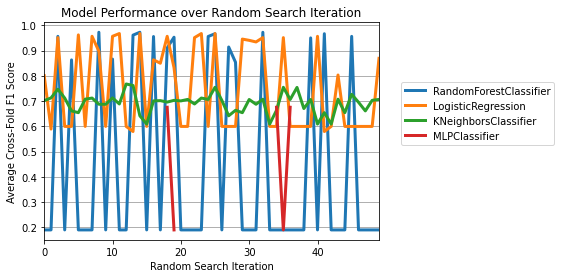

In [42]:
gridsdeath.BestF1()

Based on the Accuracy:

Best Model Accuracy Score: 0.9721
Best Model: RandomForestClassifier
Best RandomForestClassifier's Hyperparameters: {'n_estimators': 64, 'min_samples_split': 42, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 55, 'criterion': 'gini'}




(<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 {'RandomForestClassifier': 0.9721,
  'LogisticRegression': 0.9667,
  'KNeighborsClassifier': 0.7756,
  'MLPClassifier': 0.7032})

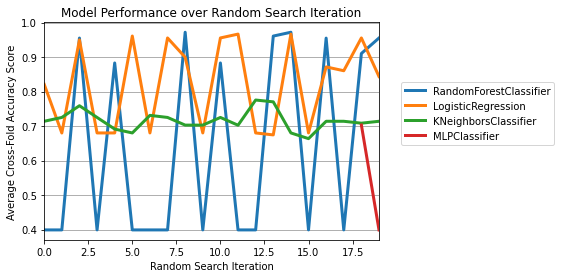

In [43]:
gridsdeath.BestAccuracy()

In [44]:
f1_model, acc_model = gridsdeath.get_models()

In [45]:
acc_model

RandomForestClassifier(max_depth=55, max_features='log2', min_samples_leaf=4,
                       min_samples_split=42, n_estimators=64, random_state=42)

In [46]:
f1_model

RandomForestClassifier(max_depth=55, max_features='log2', min_samples_leaf=4,
                       min_samples_split=42, n_estimators=64, random_state=42)

In [47]:
accuracy_model

RandomForestClassifier(max_depth=55, max_features='log2', min_samples_leaf=4,
                       min_samples_split=42, n_estimators=64, random_state=42)

In [296]:
import pickle
with open("clf_hypers.pickle", "wb") as f:
    pickle.dump(clf_hypers, f)

In [311]:
with open('output_hypers_f1.pickle', 'rb') as f:
    mynewlist = pickle.load(f)

In [312]:
mynewlist

[{'model': RandomForestClassifier(random_state=42),
  'hyperparameters': {'n_estimators': array([ 10,  12,  15,  18,  21,  24,  27,  30,  32,  35,  38,  41,  44,
           47,  50,  52,  55,  58,  61,  64,  67,  70,  72,  75,  78,  81,
           84,  87,  90,  92,  95,  98, 101, 104, 107, 110, 112, 115, 118,
          121, 124, 127, 130, 132, 135, 138, 141, 144, 147, 150]),
   'criterion': ['gini', 'entropy'],
   'max_depth': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
           33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
           57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
           81,  83,  85,  87,  88,  90,  92,  94,  96,  98, 100]),
   'min_samples_split': array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
           28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
           54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
           80,  82,  84,  86,  88